# Projet d'Apprentissage Automatique Non Supervisé
# Clustering des Hymnes Nationaux

**Membres du groupe :**
- Membre 1 Benjamin MAURY
- Membre 2 Haggar SENOUSSI
- Membre 3 Léo BOUFFARD

## Introduction

Ce projet vise à appliquer des techniques de clustering (apprentissage non supervisé) sur un ensemble de textes d'hymnes nationaux afin de découvrir des regroupements naturels entre les pays selon le contenu textuel de leurs hymnes. Nous analyserons ces clusters pour identifier d'éventuelles tendances ou similarités thématiques entre les différents pays.

Nous allons procéder en trois grandes étapes :
1. Prétraitement des textes d'hymnes nationaux
2. Application de l'algorithme des k-moyennes 
3. Application du clustering hiérarchique


## Importation des bibliothèques nécessaires

In [1]:
# Bibliothèques standards
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import string
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Pour le prétraitement des textes
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Pour le clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples
from scipy.cluster.hierarchy import dendrogram, linkage

# Pour la visualisation
import plotly.express as px
from wordcloud import WordCloud
import matplotlib.colors as mcolors
from yellowbrick.cluster import SilhouetteVisualizer
import plotly.graph_objects as go 

# Téléchargement des ressources NLTK nécessaires
nltk.download('all')

# Chargement et exploration des données

In [2]:
# Chargement du jeu de données
df = pd.read_csv('data/anthems.csv')

# Affichage des premières lignes pour comprendre la structure
print("Aperçu du jeu de données :")
display(df.head())

# Informations générales sur le jeu de données
print("\nInformations sur le jeu de données :")
display(df.info())

# Statistiques descriptives
print("\nStatistiques descriptives :")
display(df.describe(include='all'))

# Vérification des valeurs manquantes
print("\nValeurs manquantes par colonne :")
display(df.isnull().sum())

# Nombre de pays dans le jeu de données
print(f"\nNombre de pays dans le jeu de données : {df.shape[0]}")

# Exploration de quelques exemples d'hymnes
print("\nExemples d'hymnes nationaux :")
for i in range(3):
    print(f"\nPays : {df.iloc[i]['Country']}")
    print(f"Extrait de l'hymne : {df.iloc[i]['Anthem'][:300]}...")

Aperçu du jeu de données :


Country Alpha-2 Alpha-3 Continent  \
0     Albania      AL     ALB    Europe   
1     Armenia      AM     ARM    Europe   
2     Austria      AT     AUT    Europe   
3  Azerbaijan      AZ     AZE    Europe   
4     Belarus      BY     BLR    Europe   

                                              Anthem  
0  Around our flag we stand united, With one wish...  
1  Our Fatherland, free, independent, That has fo...  
2  Land of mountains, land by the river, Land of ...  
3  Azerbaijan, Azerbaijan! The glorious Fatherlan...  
4  We, Belarusians, are peaceful people, Wholehea...


Informations sur le jeu de données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Country    190 non-null    object
 1   Alpha-2    189 non-null    object
 2   Alpha-3    190 non-null    object
 3   Continent  190 non-null    object
 4   Anthem     190 non-null    object
dtypes: object(5)
memory usage: 7.5+ KB


None


Statistiques descriptives :


Country Alpha-2 Alpha-3 Continent  \
count       190     189     190       190   
unique      190     188     190         6   
top     Vietnam      CH     COG    Africa   
freq          1       2       1        56   

                                                   Anthem  
count                                                 190  
unique                                                188  
top     Arise, ye who refuse to be slaves; With our ve...  
freq                                                    2


Valeurs manquantes par colonne :


Country      0
Alpha-2      1
Alpha-3      0
Continent    0
Anthem       0
dtype: int64


Nombre de pays dans le jeu de données : 190

Exemples d'hymnes nationaux :

Pays : Albania
Extrait de l'hymne : Around our flag we stand united, With one wish and one goal, A sacred oath we bestow upon it Proclaiming loyalty for our salvation. From war abstains only he, Who a traitor is born, He who is a true man is not frightened, But dies a warrior to the cause. With weapons in our hands a-brandished, We wi...

Pays : Armenia
Extrait de l'hymne : Our Fatherland, free, independent, That has for centuries lived, Is now summoning its sons To the free, independent Armenia. Here is a flag for you, my brother, That I have sewn by hand Over the sleepless nights, And bathed in my tears. Look at it, tricolored, A valuable symbol for us. Let it shine ...

Pays : Austria
Extrait de l'hymne : Land of mountains, land by the river, Land of fields, land of cathedrals, Land of hammers, with a promising future! Home to great daughters and sons, People highly gifted for beautiful arts, Much-praised A

# Partie 1: Prétraitement des textes

## 1.1 Fonction de nettoyage superficiel

In [3]:
def nettoyage_superficiel(texte):
    """
    Effectue un nettoyage superficiel du texte :
    - Conversion en minuscules
    - Suppression des caractères spéciaux et de la ponctuation
    - Suppression des chiffres
    - Suppression des espaces multiples
    """
    if not isinstance(texte, str):
        return ""
    
    # Conversion en minuscules
    texte = texte.lower()
    
    # Suppression des URLs
    texte = re.sub(r'http\S+|www\S+|https\S+', '', texte)
    
    # Suppression des balises HTML si présentes
    texte = re.sub(r'<.*?>', '', texte)
    
    # Suppression des caractères spéciaux et de la ponctuation
    texte = re.sub(r'[^\w\s]', ' ', texte)
    
    # Suppression des chiffres
    texte = re.sub(r'\d+', '', texte)
    
    # Suppression des espaces multiples
    texte = re.sub(r'\s+', ' ', texte)
    
    # Suppression des espaces en début et fin de chaîne
    texte = texte.strip()
    
    return texte

# Application du nettoyage superficiel
df['anthem_clean'] = df['Anthem'].apply(nettoyage_superficiel)

# Affichage d'un exemple avant/après nettoyage
exemple_index = 0
print(f"Pays: {df.iloc[exemple_index]['Country']}")
print(f"\nHymne original:\n{df.iloc[exemple_index]['Anthem'][:500]}...")
print(f"\nHymne après nettoyage superficiel:\n{df.iloc[exemple_index]['anthem_clean'][:500]}...")

Pays: Albania

Hymne original:
Around our flag we stand united, With one wish and one goal, A sacred oath we bestow upon it Proclaiming loyalty for our salvation. From war abstains only he, Who a traitor is born, He who is a true man is not frightened, But dies a warrior to the cause. With weapons in our hands a-brandished, We will defend our fatherland, Our sacred rights weÃ¢â‚¬â„¢ll not relinquish, The foe has no place in our land. For God himself proclaimed The nations of the earth shall wane, And yet will live, will thriv...

Hymne après nettoyage superficiel:
around our flag we stand united with one wish and one goal a sacred oath we bestow upon it proclaiming loyalty for our salvation from war abstains only he who a traitor is born he who is a true man is not frightened but dies a warrior to the cause with weapons in our hands a brandished we will defend our fatherland our sacred rights weã â â ll not relinquish the foe has no place in our land for god himself proclaimed the nati

## 1.2 Suppression des stop words

In [4]:
def supprimer_stopwords(texte, langue='english'):
    """
    Supprime les stop words (mots vides) du texte.
    """
    if not isinstance(texte, str) or texte == "":
        return ""
    
    try:
        # Récupération des stop words pour la langue spécifiée
        # Vérification que les stopwords sont bien disponibles
        if langue not in stopwords.fileids():
            print(f"Attention: langue '{langue}' non disponible dans NLTK stopwords")
            print(f"Langues disponibles: {stopwords.fileids()}")
            # Utilisation d'une liste vide si la langue n'est pas disponible
            stop_words = set()
        else:
            stop_words = set(stopwords.words(langue))
        
        # Tokenisation du texte
        tokens = word_tokenize(texte)
        
        # Suppression des stop words
        tokens_filtered = [mot for mot in tokens if mot not in stop_words]
        
        # Reconstruction du texte
        texte_sans_stopwords = ' '.join(tokens_filtered)
        
        return texte_sans_stopwords
    
    except LookupError as e:
        print(f"Erreur NLTK: {e}")
        print("Essai de téléchargement des ressources manquantes...")
        nltk.download('stopwords')
        nltk.download('punkt')
        # Deuxième tentative après téléchargement
        return supprimer_stopwords(texte, langue)
    except Exception as e:
        print(f"Erreur inattendue: {e}")
        return texte  # Retourne le texte original en cas d'erreur

# Application de la suppression des stop words
# Ajout d'une gestion d'erreur au cas où
try:
    df['anthem_no_stopwords'] = df['anthem_clean'].apply(supprimer_stopwords)
except Exception as e:
    print(f"Erreur lors de la suppression des stop words: {e}")
    print("Utilisation du texte nettoyé sans suppression des stop words...")
    df['anthem_no_stopwords'] = df['anthem_clean']

# Affichage d'un exemple avant/après suppression des stop words
print(f"\nHymne après nettoyage superficiel:\n{df.iloc[exemple_index]['anthem_clean'][:500]}...")
print(f"\nHymne après suppression des stop words:\n{df.iloc[exemple_index]['anthem_no_stopwords'][:500]}...")


Hymne après nettoyage superficiel:
around our flag we stand united with one wish and one goal a sacred oath we bestow upon it proclaiming loyalty for our salvation from war abstains only he who a traitor is born he who is a true man is not frightened but dies a warrior to the cause with weapons in our hands a brandished we will defend our fatherland our sacred rights weã â â ll not relinquish the foe has no place in our land for god himself proclaimed the nations of the earth shall wane and yet will live will thrive albania for y...

Hymne après suppression des stop words:
around flag stand united one wish one goal sacred oath bestow upon proclaiming loyalty salvation war abstains traitor born true man frightened dies warrior cause weapons hands brandished defend fatherland sacred rights weã â â relinquish foe place land god proclaimed nations earth shall wane yet live thrive albania fight flag flag sacred symbol upon swear albania dear fatherland honour glory brave man named honoured

## 1.3 Racinisation et lemmatisation

In [5]:
# Initialisation des outils
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def racinisation(texte):
    """
    Applique la racinisation (stemming) aux mots du texte.
    """
    if not isinstance(texte, str) or texte == "":
        return ""
    
    # Tokenisation
    tokens = word_tokenize(texte)
    
    # Racinisation
    tokens_stemmed = [stemmer.stem(mot) for mot in tokens]
    
    # Reconstruction du texte
    texte_stemmed = ' '.join(tokens_stemmed)
    
    return texte_stemmed

def lemmatisation(texte):
    """
    Applique la lemmatisation aux mots du texte.
    """
    if not isinstance(texte, str) or texte == "":
        return ""
    
    # Tokenisation
    tokens = word_tokenize(texte)
    
    # Lemmatisation (par défaut considère les mots comme des noms)
    tokens_lemmatized = [lemmatizer.lemmatize(mot) for mot in tokens]
    
    # Reconstruction du texte
    texte_lemmatized = ' '.join(tokens_lemmatized)
    
    return texte_lemmatized

# Application de la racinisation et de la lemmatisation
df['anthem_stemmed'] = df['anthem_no_stopwords'].apply(racinisation)
df['anthem_lemmatized'] = df['anthem_no_stopwords'].apply(lemmatisation)

# Affichage des résultats pour un exemple
print(f"\nHymne après suppression des stop words:\n{df.iloc[exemple_index]['anthem_no_stopwords'][:300]}...")
print(f"\nHymne après racinisation:\n{df.iloc[exemple_index]['anthem_stemmed'][:300]}...")
print(f"\nHymne après lemmatisation:\n{df.iloc[exemple_index]['anthem_lemmatized'][:300]}...")

# Comparaison des résultats sur un petit échantillon de mots
exemple_texte = df.iloc[exemple_index]['anthem_no_stopwords']
tokens_exemple = word_tokenize(exemple_texte)[:10]
resultats_comparaison = pd.DataFrame({
    'Mot original': tokens_exemple,
    'Racinisation': [stemmer.stem(mot) for mot in tokens_exemple],
    'Lemmatisation': [lemmatizer.lemmatize(mot) for mot in tokens_exemple]
})
display(resultats_comparaison)

# Pour notre analyse, nous choisissons la lemmatisation car elle préserve mieux le sens des mots
texte_pretraite = df['anthem_lemmatized']


Hymne après suppression des stop words:
around flag stand united one wish one goal sacred oath bestow upon proclaiming loyalty salvation war abstains traitor born true man frightened dies warrior cause weapons hands brandished defend fatherland sacred rights weã â â relinquish foe place land god proclaimed nations earth shall wane yet liv...

Hymne après racinisation:
around flag stand unit one wish one goal sacr oath bestow upon proclaim loyalti salvat war abstain traitor born true man frighten die warrior caus weapon hand brandish defend fatherland sacr right weã â â relinquish foe place land god proclaim nation earth shall wane yet live thrive albania fight fl...

Hymne après lemmatisation:
around flag stand united one wish one goal sacred oath bestow upon proclaiming loyalty salvation war abstains traitor born true man frightened dy warrior cause weapon hand brandished defend fatherland sacred right weã â â relinquish foe place land god proclaimed nation earth shall wane yet live 

Mot original Racinisation Lemmatisation
0       around       around        around
1         flag         flag          flag
2        stand        stand         stand
3       united         unit        united
4          one          one           one
5         wish         wish          wish
6          one          one           one
7         goal         goal          goal
8       sacred         sacr        sacred
9         oath         oath          oath

## 1.4 Analyse des fréquences des mots

Les 20 mots les plus fréquents dans les hymnes :
u: 249
land: 213
may: 154
god: 135
let: 135
people: 134
one: 108
nation: 105
free: 105
thy: 105
glory: 96
country: 94
shall: 93
homeland: 91
freedom: 90
love: 86
thee: 79
flag: 73
peace: 72
live: 71


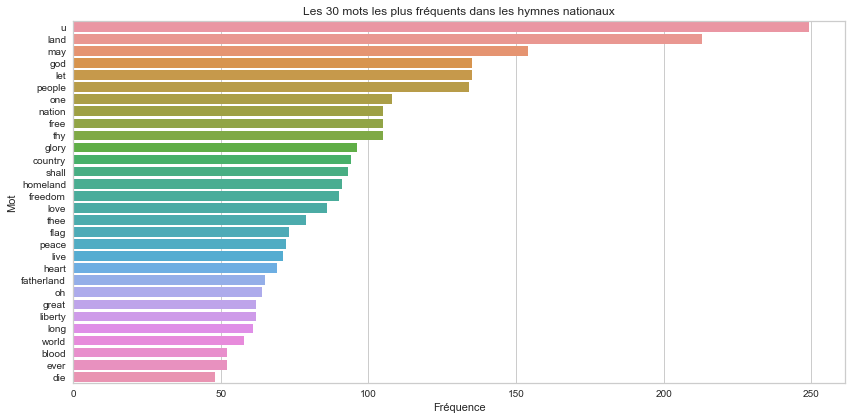

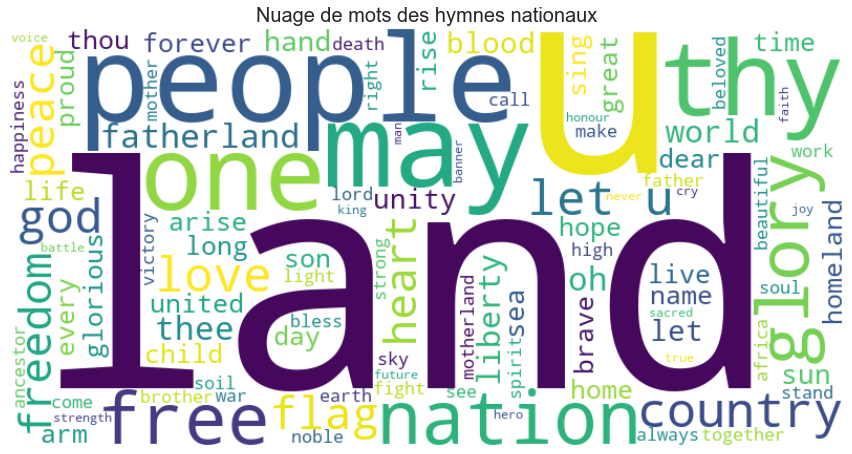

In [6]:
# Création d'un grand texte contenant tous les hymnes prétraités
tous_les_hymnes = ' '.join(df['anthem_lemmatized'].dropna())

# Tokenisation
tous_les_tokens = word_tokenize(tous_les_hymnes)

# Comptage des fréquences
freq_mots = Counter(tous_les_tokens)

# Affichage des 20 mots les plus fréquents
print("Les 20 mots les plus fréquents dans les hymnes :")
for mot, freq in freq_mots.most_common(20):
    print(f"{mot}: {freq}")

# Visualisation des 30 mots les plus fréquents
mots_freq = pd.DataFrame(freq_mots.most_common(30), columns=['Mot', 'Fréquence'])
plt.figure(figsize=(12, 6))
sns.barplot(x='Fréquence', y='Mot', data=mots_freq)
plt.title('Les 30 mots les plus fréquents dans les hymnes nationaux')
plt.tight_layout()
plt.show()

# Nuage de mots global
plt.figure(figsize=(12, 8))
wordcloud = WordCloud(width=800, height=400, background_color='white', 
                     max_words=100, contour_width=3, contour_color='steelblue')
wordcloud.generate(tous_les_hymnes)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de mots des hymnes nationaux', fontsize=20)
plt.tight_layout()
plt.show()

## 1.5 Vectorisation des textes

Dimensions de la matrice Bag of Words: (190, 1323)
Nombre de mots uniques dans le vocabulaire: 1323

Aperçu du vocabulaire:
abandon: index 0
able: index 1
abundance: index 2
accompanied: index 3
accord: index 4
achieve: index 5
achieved: index 6
acquired: index 7
across: index 8
action: index 9

Dimensions de la matrice TF-IDF: (190, 1323)

Aperçu de la matrice TF-IDF (5 premières lignes, 5 premières colonnes):


abandon  able  abundance  accompanied  accord
0      0.0   0.0        0.0          0.0     0.0
1      0.0   0.0        0.0          0.0     0.0
2      0.0   0.0        0.0          0.0     0.0
3      0.0   0.0        0.0          0.0     0.0
4      0.0   0.0        0.0          0.0     0.0


Mots les plus importants pour Albania:
  - sacred: 0.3243
  - fatherland: 0.2630
  - upon: 0.2280
  - flag: 0.2277
  - one: 0.2098

Mots les plus importants pour Armenia:
  - dy: 0.4513
  - independent: 0.3994
  - bathed: 0.2257
  - lived: 0.2153
  - free: 0.2152

Mots les plus importants pour Austria:
  - much: 0.4988
  - land: 0.2657
  - thou: 0.2169
  - bravely: 0.1663
  - continent: 0.1663


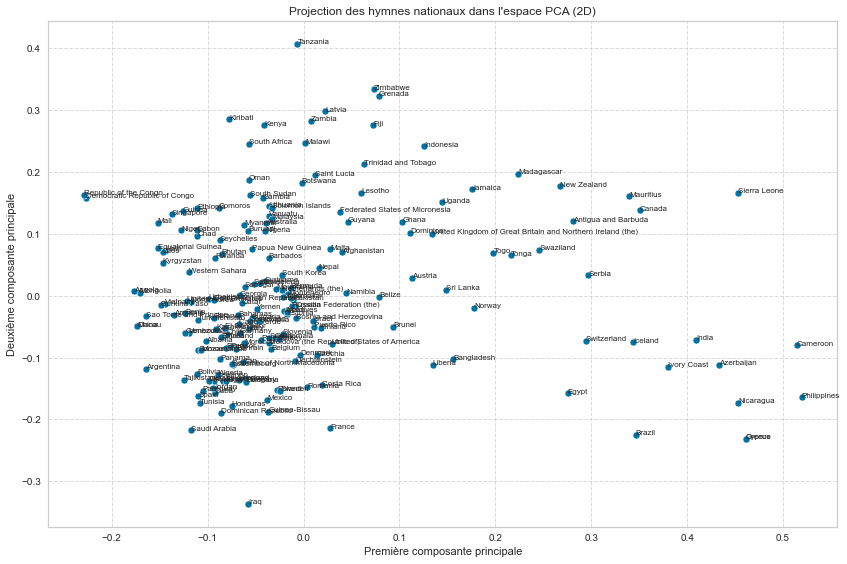

Variance expliquée par les deux premières composantes principales: 4.19%
Variance expliquée par la première composante: 2.41%
Variance expliquée par la deuxième composante: 1.78%


In [7]:
# Vectorisation avec CountVectorizer (Bag of Words)
count_vectorizer = CountVectorizer(min_df=2, max_df=0.95)
X_count = count_vectorizer.fit_transform(df['anthem_lemmatized'].fillna(''))

# Affichage de la forme de la matrice résultante
print(f"Dimensions de la matrice Bag of Words: {X_count.shape}")
print(f"Nombre de mots uniques dans le vocabulaire: {len(count_vectorizer.vocabulary_)}")

# Liste des mots dans le vocabulaire
print("\nAperçu du vocabulaire:")
vocab_count = count_vectorizer.vocabulary_
vocab_items = list(vocab_count.items())
for i, (mot, index) in enumerate(sorted(vocab_items, key=lambda x: x[1])[:10]):
    print(f"{mot}: index {index}")

# Vectorisation avec TF-IDF
tfidf_vectorizer = TfidfVectorizer(min_df=2, max_df=0.95)
X_tfidf = tfidf_vectorizer.fit_transform(df['anthem_lemmatized'].fillna(''))

print(f"\nDimensions de la matrice TF-IDF: {X_tfidf.shape}")

# Conversion en DataFrame pour plus de lisibilité
feature_names = tfidf_vectorizer.get_feature_names_out()
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=feature_names)

# Affichage d'un aperçu de la matrice TF-IDF
print("\nAperçu de la matrice TF-IDF (5 premières lignes, 5 premières colonnes):")
display(df_tfidf.iloc[:5, :5])

# Pour chaque hymne, trouver les 5 mots les plus importants selon TF-IDF
def mots_importants_tfidf(index_pays, n=5):
    """Retourne les n mots les plus importants pour un pays donné selon TF-IDF."""
    tfidf_scores = list(zip(feature_names, X_tfidf[index_pays].toarray()[0]))
    tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
    return tfidf_scores[:n]

# Affichage des mots les plus importants pour 3 pays
for i in range(3):
    pays = df.iloc[i]['Country']
    mots_top = mots_importants_tfidf(i)
    print(f"\nMots les plus importants pour {pays}:")
    for mot, score in mots_top:
        print(f"  - {mot}: {score:.4f}")

# Sauvegarde des matrices de vectorisation pour les prochaines étapes
# Pour notre analyse, nous utiliserons la matrice TF-IDF qui capture mieux l'importance des mots
X = X_tfidf

# Ajout d'une réduction de dimension PCA pour visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

# Création d'un DataFrame pour faciliter la visualisation
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['Country'] = df['Country'].values

# Visualisation des pays dans l'espace PCA
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', data=df_pca)

# Ajout des noms de pays comme annotations
for i, row in df_pca.iterrows():
    plt.annotate(row['Country'], (row['PC1'], row['PC2']), fontsize=8)

plt.title('Projection des hymnes nationaux dans l\'espace PCA (2D)')
plt.xlabel('Première composante principale')
plt.ylabel('Deuxième composante principale')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Variance expliquée par les composantes principales
explained_variance = pca.explained_variance_ratio_
print(f"Variance expliquée par les deux premières composantes principales: {sum(explained_variance):.2%}")
print(f"Variance expliquée par la première composante: {explained_variance[0]:.2%}")
print(f"Variance expliquée par la deuxième composante: {explained_variance[1]:.2%}")

# Partie 2: Partitionnement en K means

## 2.1 Application du K means

In [8]:
inertias = []
silhouettes = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
    kmeans.fit(X_tfidf)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_tfidf, kmeans.labels_))


## 2.2 Méthode du coude

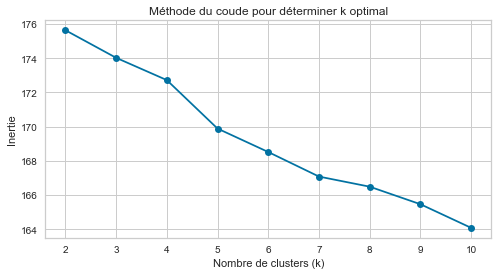

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie")
plt.title("Méthode du coude pour déterminer k optimal")
plt.grid(True)
plt.show()


Ici la cassure se fait clairement à 5, on en a également une légère sur 7

## 2.3 Méthode silhouette

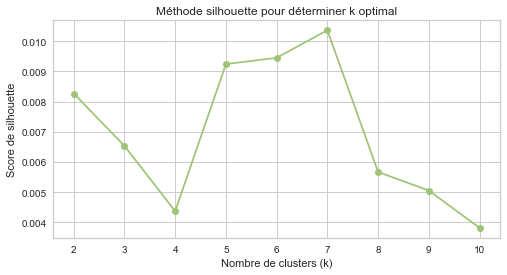

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(K_range, silhouettes, 'go-')
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Score de silhouette")
plt.title("Méthode silhouette pour déterminer k optimal")
plt.grid(True)
plt.show()


Le maximum de cette méthode est 7, ce qui est cohérent avec la méthode du coude.

On selectionnera donc 7 comme nombre de clusters optimal

## 2.4 Clusterisation des valeurs

In [11]:
k_optimal = 7
kmeans_final = KMeans(n_clusters=k_optimal, random_state=0, n_init='auto')
df_pca['cluster'] = kmeans_final.fit_predict(X)
df['cluster'] = kmeans_final.fit_predict(X)


repartition = df['cluster'].value_counts().sort_index()
print("Répartition des pays par cluster :")
print(repartition)


Répartition des pays par cluster :
0    29
1    25
2    19
3    13
4    26
5    25
6    53
Name: cluster, dtype: int64


In [12]:
print("\nPays par cluster:")
for cluster_id in range(k_optimal):
    pays_cluster = df[df['cluster'] == cluster_id]['Country'].tolist()
    print(f"\nCluster {cluster_id} ({len(pays_cluster)} pays):")
    print(", ".join(pays_cluster))


Pays par cluster:

Cluster 0 (29 pays):
Belarus, Czechia, Netherlands (the), Russian Federation (the), Ukraine, Suriname, Honduras, Panama, Greenland, Afghanistan, Bahrain, Brunei, Cambodia, Iran, Kazakhstan, Kuwait, Lebanon, Mongolia, Pakistan, Palestine, Saudi Arabia, South Korea, Syria, Turkmenistan, United Arab Emirates, Uzbekistan, Libya, Namibia, Sao Tome and Principe

Cluster 1 (25 pays):
Croatia, Georgia, Hungary, Montenegro, Chile, Colombia, United States of America, Guatemala, Cuba, Puerto Rico, Samoa, Kyrgyzstan, Maldives, Tajikistan, Thailand, Algeria, Benin, Burkina Faso, Chad, Djibouti, Gabon, Guinea-Bissau, Mauritania, Senegal, Somalia

Cluster 2 (19 pays):
Bosnia and Herzegovina, Bulgaria, Denmark, Luxembourg, Republic of North Macedonia, Romania, Costa Rica, Bermuda, Solomon Islands, Federated States of Micronesia, Jordan, Yemen, Cape Verde, Comoros, Equatorial Guinea, Lesotho, Liberia, Saint Helena, Uganda

Cluster 3 (13 pays):
Latvia, Jamaica, Trinidad and Tobago, F

Résultats observés :
- Répartition inégale : Cluster 6 contient 53 pays, contre 13 à 29 pays pour les autres clusters.

- 7 clusters identifiés, avec des tailles variées allant de 13 à 53 pays.

Conclusions :
- Le Cluster 6, très large (53 pays), regroupe probablement des hymnes partageant des thèmes très répandus ou universels (ex : patrie, liberté, espoir).

- Les clusters plus restreints (ex : Cluster 3, 13 pays) pourraient refléter des spécificités culturelles, régionales ou linguistiques particulières dans les hymnes.

- Cette distribution suggère une diversité modérée dans les styles et thèmes des hymnes, avec une prévalence de motifs communs à une majorité de nations.

## 2.5 Représentation graphique

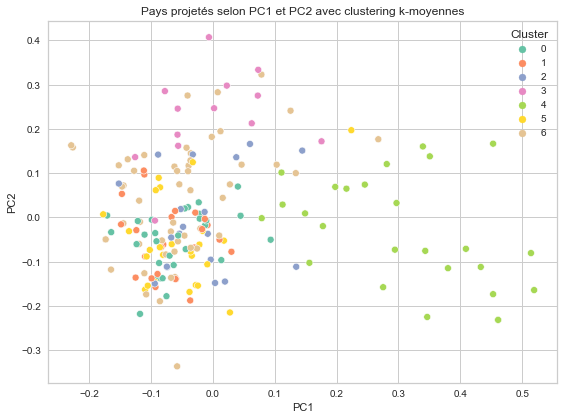

In [13]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='Set2')
plt.title('Pays projetés selon PC1 et PC2 avec clustering k-moyennes')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

Très diffu, pas vraiment de sens à afficher le résultat comme ça, on voit tout de même que le cluster 4 est à part

In [14]:
df_map = df.copy()
df_map['cluster'] = df_map['cluster'].astype(str)
    
fig = px.choropleth(df_map,
                    locations='Alpha-3',
                    color='cluster',
                    hover_name='Country',
                    color_discrete_sequence=px.colors.qualitative.Set3,
                    title=f'Clustering K-means des hymnes nationaux ({k_optimal} clusters)')
    
fig.update_layout(
    title_font_size=16,
    geo=dict(showframe=False, showcoastlines=True)
)
    
fig.show()


Une vraie cohérence avec cet affichage, on voit des pays qui par zone ont les mêmes clusters comme l'Europe ou les pays de l'Est. Ce qui est cohérent avec une histoire commune et une culture régionale

## 2.6 Mots par pays

In [15]:
def get_top_words_by_cluster(cluster_id, n_words=20):
    """
    Retourne les mots les plus fréquents pour un cluster donné.
    """
    cluster_mask = df['cluster'] == cluster_id
    cluster_texts = df[cluster_mask]['anthem_lemmatized'].fillna('')
    
    cluster_text = ' '.join(cluster_texts)
    
    tokens = word_tokenize(cluster_text)
    word_freq = Counter(tokens)
    
    return word_freq.most_common(n_words)

print("\nAnalyse des mots les plus fréquents par cluster:")
for cluster_id in range(k_optimal):
    print(f"\n--- Cluster {cluster_id} ---")
    top_words = get_top_words_by_cluster(cluster_id)
    for word, freq in top_words[:10]:
        print(f"{word}: {freq}")


Analyse des mots les plus fréquents par cluster:

--- Cluster 0 ---
country: 55
land: 32
people: 25
u: 24
glory: 20
god: 19
flag: 16
great: 16
may: 14
live: 13

--- Cluster 1 ---
may: 28
u: 23
people: 21
oh: 20
flag: 20
homeland: 17
land: 16
freedom: 15
free: 15
sea: 14

--- Cluster 2 ---
u: 22
island: 19
hail: 19
land: 17
heart: 16
sing: 14
liberty: 14
live: 13
always: 11
long: 10

--- Cluster 3 ---
bless: 31
u: 22
land: 19
god: 16
people: 14
africa: 14
may: 12
oh: 11
protect: 11
love: 10

--- Cluster 4 ---
thy: 89
thee: 57
land: 44
thou: 37
u: 30
love: 27
god: 24
ever: 22
canada: 20
stand: 18

--- Cluster 5 ---
fatherland: 46
u: 35
shall: 28
land: 25
one: 18
world: 17
arm: 17
glory: 16
may: 16
god: 15

--- Cluster 6 ---
u: 93
let: 81
may: 69
land: 60
one: 57
free: 54
nation: 49
people: 48
god: 47
homeland: 43


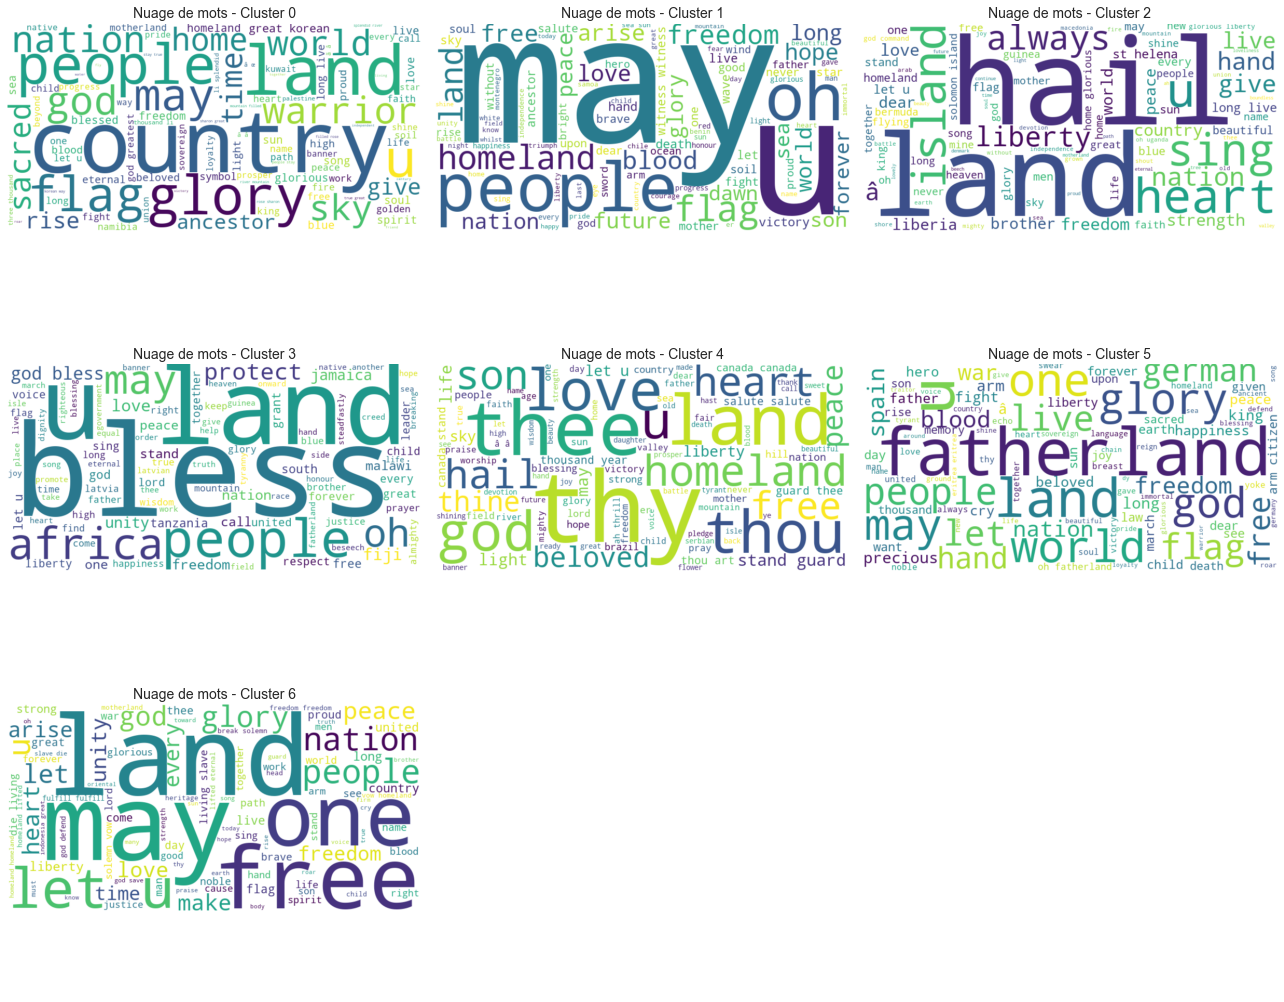

In [16]:
clusters = sorted(df_pca['cluster'].unique())
n_clusters = len(clusters)
n_cols = 3
n_rows = (n_clusters + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))

for i, c in enumerate(clusters):
    textes = df[df_pca['cluster'] == c]['anthem_lemmatized'].dropna()
    texte_total = ' '.join(textes)
    
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(texte_total)
    
    row, col = divmod(i, n_cols)
    ax = axes[row, col] if n_rows > 1 else axes[col]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Nuage de mots - Cluster {c}', fontsize=14)
    ax.axis('off')

# Masquer les sous-graphiques inutilisés s'il y en a
for j in range(i + 1, n_rows * n_cols):
    row, col = divmod(j, n_cols)
    ax = axes[row, col] if n_rows > 1 else axes[col]
    ax.axis('off')

plt.tight_layout()
plt.show()


Résultats observés :
- Cluster 0 : "country" (55), "land" (32), "people" (25) → Fierté nationale et unité

- Cluster 1 : "may" (28), "flag" (20), "freedom" (15) → Vœux patriotiques et symboles

- Cluster 2 : "hail" (19), "island" (19), "liberty" (14) → Hommage aux nations insulaires et à la liberté

- Cluster 3 : "bless" (31), "africa" (14), "god" (16) → Religiosité et ancrage africain

- Cluster 4 : "thy" (89), "thee" (57), "thou" (37) → Langage archaïque à connotation solennelle

- Cluster 5 : "fatherland" (46), "shall" (28), "glory" (16) → Tonalité solennelle et militaro-patriotique

- Cluster 6 : "let" (81), "free" (54), "nation" (49) → Appel à la liberté et unité nationale

Conclusions :
- Segmentation thématique nette : chaque cluster correspond à un style linguistique ou symbolique distinct

- Cluster 4 : Influence marquée des hymnes de tradition anglaise ou chrétienne (langage biblique)

- Cluster 3 : Caractérisation forte des hymnes africains, à dimension religieuse et collective

- Cluster 6 : Vocabulaire universel orienté vers la liberté, l’unité, et le peuple

Ces résultats suggèrent une diversité culturelle et rhétorique importante dans les hymnes nationaux.

## 2.7 Analyse comparative des continents par cluster


In [17]:
print("\nRépartition des continents par cluster:")
continent_cluster_analysis = pd.crosstab(df['Continent'], df['cluster'])
display(continent_cluster_analysis)


Répartition des continents par cluster:


cluster         0   1  2  3  4   5   6
Continent                             
Africa          3  10  7  7  7   6  16
Asia           17   4  2  1  4   2  14
Europe          5   4  6  1  8  14   6
North_America   3   4  2  2  5   1   7
Oceania         0   1  2  2  1   0   4
South_America   1   2  0  0  1   2   6

<Figure size 864x576 with 0 Axes>

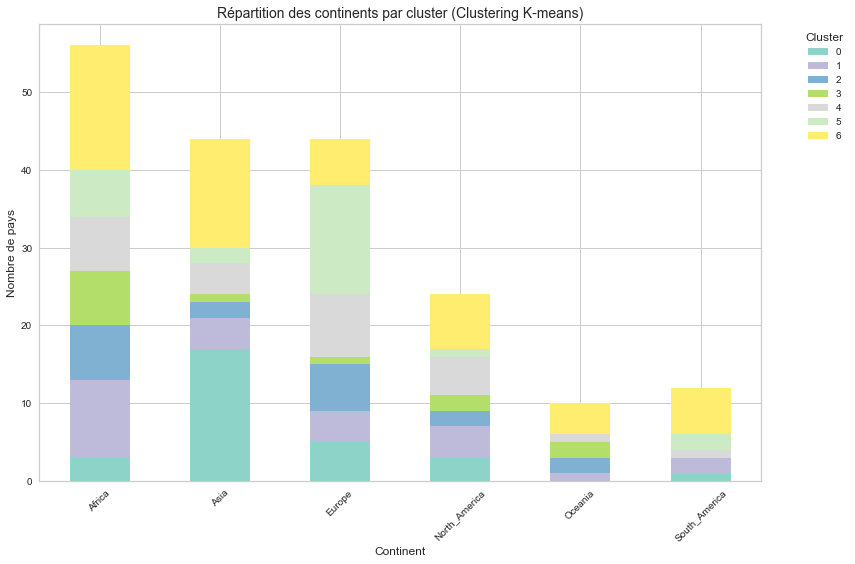

In [18]:
plt.figure(figsize=(12, 8))
continent_cluster_analysis.plot(kind='bar', stacked=True, 
                               colormap='Set3', figsize=(12, 8))
plt.title('Répartition des continents par cluster (Clustering K-means)', fontsize=14)
plt.xlabel('Continent', fontsize=12)
plt.ylabel('Nombre de pays', fontsize=12)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
continent_cluster_percent = pd.crosstab(df['Continent'], df['cluster'], 
                                       normalize='index') * 100
print("\nPourcentages de répartition des continents par cluster:")
display(continent_cluster_percent.round(1))


Pourcentages de répartition des continents par cluster:


cluster           0     1     2     3     4     5     6
Continent                                              
Africa          5.4  17.9  12.5  12.5  12.5  10.7  28.6
Asia           38.6   9.1   4.5   2.3   9.1   4.5  31.8
Europe         11.4   9.1  13.6   2.3  18.2  31.8  13.6
North_America  12.5  16.7   8.3   8.3  20.8   4.2  29.2
Oceania         0.0  10.0  20.0  20.0  10.0   0.0  40.0
South_America   8.3  16.7   0.0   0.0   8.3  16.7  50.0

Résultats observés :
- Cluster 6 : Majoritairement africain (28.6%) et asiatique (31.8%) → Cluster très représentatif du Sud global

- Cluster 0 : Fortement asiatique (38.6%), mais aussi présent sur tous les continents → Cluster le plus diversifié

- Cluster 5 : Dominé par l’Europe (31.8%), suivi par l’Afrique (10.7%) → Marqué par des hymnes européens classiques

- Cluster 2 : Représentation importante d’Océanie (20%) → Unicité régionale malgré effectif réduit

Conclusions :
- Pas de correspondance stricte entre clusters et continents : Les textes d’hymnes nationaux montrent des similarités qui dépassent la simple géographie.

- Cluster 0 illustre une diversité culturelle significative, potentiellement marquée par des thèmes communs universels.

- Cluster 6 reflète un regroupement de pays du Sud, où l’influence post-coloniale ou régionale peut expliquer les similarités textuelles.

- Certains clusters révèlent une orientation régionale plus forte (ex : Cluster 5 très européen), mais cela reste l’exception.

- Les structures lexicales et les thèmes des hymnes semblent davantage liés à l’histoire, aux régimes politiques et aux influences linguistiques qu’aux seules localisations géographiques.

## 2.8 Comparaison avec une classification géographique


In [20]:
print("\nAnalyse de cohérence géographique:")
for cluster_id in range(k_optimal):
    cluster_countries = df[df['cluster'] == cluster_id]
    continents_in_cluster = cluster_countries['Continent'].value_counts()
    
    print(f"\nCluster {cluster_id}:")
    print(f"Continents représentés: {continents_in_cluster.to_dict()}")
    
    if len(continents_in_cluster) > 0:
        proportions = continents_in_cluster / continents_in_cluster.sum()
        entropy = -np.sum(proportions * np.log2(proportions))
        print(f"Entropie géographique: {entropy:.3f}")
        
        if entropy < 1.0:
            print("Cluster géographiquement homogène")
        elif entropy < 2.0:
            print("Cluster géographiquement moyennement diversifié")
        else:
            print("Cluster géographiquement très diversifié")

print("\n" + "="*80)
print("RÉSUMÉ DU CLUSTERING K-MEAN")
print("="*80)
print(f"Nombre optimal de clusters: {k_optimal}")
print("="*80)


Analyse de cohérence géographique:

Cluster 0:
Continents représentés: {'Asia': 17, 'Europe': 5, 'North_America': 3, 'Africa': 3, 'South_America': 1}
Entropie géographique: 1.734
Cluster géographiquement moyennement diversifié

Cluster 1:
Continents représentés: {'Africa': 10, 'North_America': 4, 'Asia': 4, 'Europe': 4, 'South_America': 2, 'Oceania': 1}
Entropie géographique: 2.275
Cluster géographiquement très diversifié

Cluster 2:
Continents représentés: {'Africa': 7, 'Europe': 6, 'North_America': 2, 'Asia': 2, 'Oceania': 2}
Entropie géographique: 2.082
Cluster géographiquement très diversifié

Cluster 3:
Continents représentés: {'Africa': 7, 'North_America': 2, 'Oceania': 2, 'Asia': 1, 'Europe': 1}
Entropie géographique: 1.881
Cluster géographiquement moyennement diversifié

Cluster 4:
Continents représentés: {'Europe': 8, 'Africa': 7, 'North_America': 5, 'Asia': 4, 'Oceania': 1, 'South_America': 1}
Entropie géographique: 2.267
Cluster géographiquement très diversifié

Cluster 5:


Résultats observés :
- 3 clusters moyennement diversifiés (Clusters 0, 3, 5 ; entropie ≈ 1.7–1.8)

- 4 clusters très diversifiés géographiquement (Clusters 1, 2, 4, 6 ; entropie ≥ 2.0)

- Cluster 6 : le plus hétérogène (entropie = 2.408), couvrant tous les continents

- Aucun cluster entièrement homogène géographiquement

Conclusions :
- La majorité des clusters affichent une forte diversité géographique, indiquant que les similarités textuelles des hymnes ne suivent pas des frontières continentales strictes

- Les thèmes nationaux transcendent les continents, souvent façonnés par des trajectoires historiques partagées (colonisation, révolutions, mouvements d’indépendance)

- Les clusters les moins diversifiés restent modérément cohérents géographiquement, mais aucun regroupement strictement régional n’émerge

- Globalement, ce clustering confirme que la géographie seule ne suffit pas à expliquer la segmentation thématique ou stylistique des hymnes

### Le clustering K-means révèle que :

* Les hymnes nationaux se regroupent en **7 grands ensembles thématiquement distincts**, bien que certains soient très dominants en taille
* Chaque cluster présente des **caractéristiques stylistiques marquées** : archaïsmes, prières, vœux patriotiques ou encore références à la liberté
* La **distribution géographique est très hétérogène**, soulignant que **les ressemblances textuelles transcendent les continents**
* Les clusters révèlent des **dynamiques linguistiques et culturelles partagées**, souvent liées à l’histoire coloniale ou aux idéaux républicains
* Malgré des tailles de clusters inégales, la segmentation K-means met en évidence des **familles textuelles cohérentes**, utiles pour une lecture typologique du corpus


# Partie 3: Partitionnement hiérarchique

## 3.1 Application du clustering hiérarchique


Calcul de la matrice de liaison pour le clustering hiérarchique...


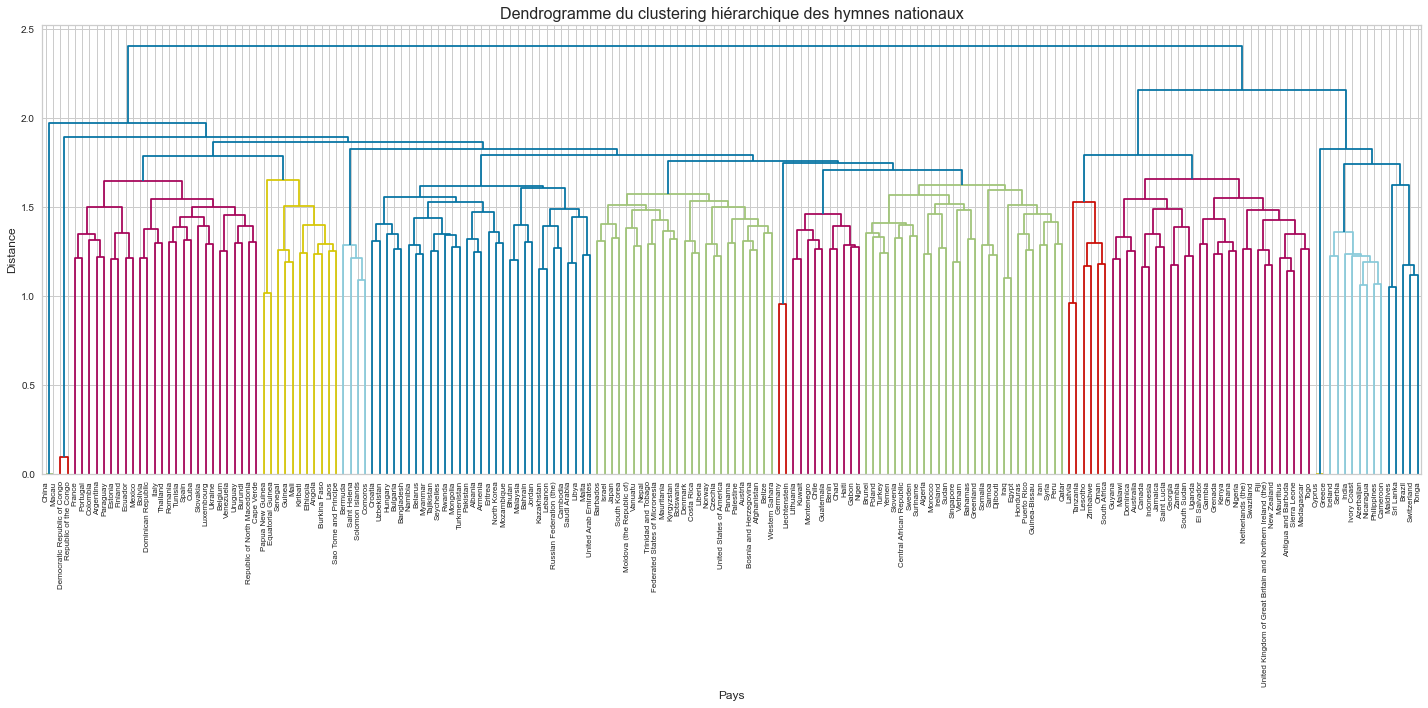

In [21]:
print("Calcul de la matrice de liaison pour le clustering hiérarchique...")
linkage_matrix = linkage(X_tfidf.toarray(), method='ward')

plt.figure(figsize=(20, 10))
dendrogram(linkage_matrix, 
           labels=df['Country'].values,
           orientation='top',
           leaf_rotation=90,
           leaf_font_size=8)
plt.title('Dendrogramme du clustering hiérarchique des hymnes nationaux', fontsize=16)
plt.xlabel('Pays', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.tight_layout()
plt.show()

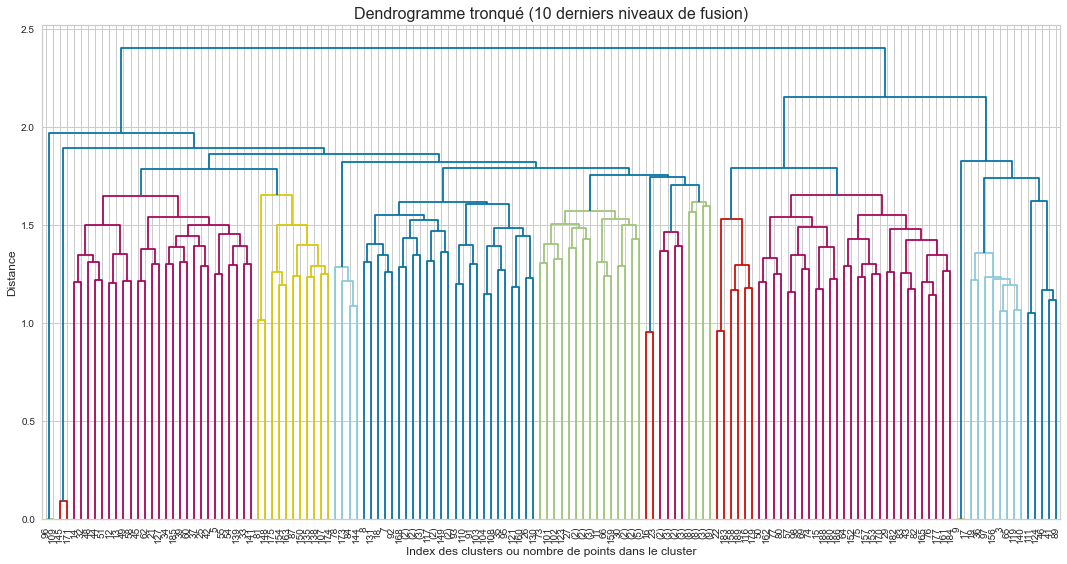

In [22]:
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, 
           truncate_mode='level',
           p=10,  
           show_leaf_counts=True,
           leaf_rotation=90,
           leaf_font_size=10)
plt.title('Dendrogramme tronqué (10 derniers niveaux de fusion)', fontsize=16)
plt.xlabel('Index des clusters ou nombre de points dans le cluster', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.tight_layout()
plt.show()

Résultats observés :

- Le dendrogramme montre une structure hiérarchique avec différents niveaux de fusion
- Les pays se regroupent graduellement selon leurs similarités textuelles

Conclusions :

- La structure arborescente révèle des regroupements naturels entre pays basés sur le contenu de leurs hymnes
- Les distances de fusion indiquent le degré de similarité : plus la fusion se fait à une distance élevée, moins les groupes sont similaires
- Le dendrogramme tronqué suggère qu'un nombre optimal de clusters se situe entre 5 et 15

## 3.2 Détermination du nombre optimal de clusters


In [23]:
def calculate_wcss_hierarchical(X, max_k=15):
    """
    Calcule la somme des carrés intra-cluster (WCSS) pour différents nombres de clusters
    dans le cadre du clustering hiérarchique.
    """
    wcss_values = []
    k_values = range(2, max_k + 1)
    
    for k in k_values:
        # Application du clustering hiérarchique avec k clusters
        hierarchical = AgglomerativeClustering(n_clusters=k, linkage='ward')
        cluster_labels = hierarchical.fit_predict(X.toarray())
        
        # Calcul de la WCSS
        wcss = 0
        for i in range(k):
            cluster_points = X.toarray()[cluster_labels == i]
            if len(cluster_points) > 0:
                centroid = cluster_points.mean(axis=0)
                wcss += np.sum((cluster_points - centroid) ** 2)
        
        wcss_values.append(wcss)
        print(f"k={k}: WCSS={wcss:.2f}")
    
    return k_values, wcss_values

In [24]:
# Calcul de la WCSS pour différentes valeurs de k
print("Calcul de la WCSS pour différentes valeurs de k...")
k_range, wcss_values = calculate_wcss_hierarchical(X_tfidf, max_k=15)

Calcul de la WCSS pour différentes valeurs de k...
k=2: WCSS=175.14
k=3: WCSS=172.82
k=4: WCSS=170.88
k=5: WCSS=169.09
k=6: WCSS=167.35
k=7: WCSS=165.69
k=8: WCSS=164.03
k=9: WCSS=162.42
k=10: WCSS=160.82
k=11: WCSS=159.23
k=12: WCSS=157.69
k=13: WCSS=156.17
k=14: WCSS=154.66
k=15: WCSS=153.21


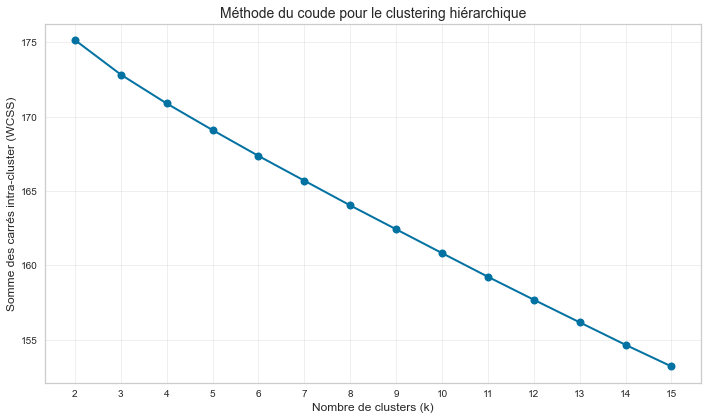

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss_values, 'bo-', linewidth=2, markersize=8)
plt.title('Méthode du coude pour le clustering hiérarchique', fontsize=14)
plt.xlabel('Nombre de clusters (k)', fontsize=12)
plt.ylabel('Somme des carrés intra-cluster (WCSS)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.tight_layout()
plt.show()

In [26]:
# Calcul du score de silhouette pour différentes valeurs de k
silhouette_scores = []
k_values_silhouette = range(2, 11)

print("\nCalcul des scores de silhouette...")
for k in k_values_silhouette:
    hierarchical = AgglomerativeClustering(n_clusters=k, linkage='ward')
    cluster_labels = hierarchical.fit_predict(X_tfidf.toarray())
    silhouette_avg = silhouette_score(X_tfidf.toarray(), cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"k={k}: Score de silhouette={silhouette_avg:.4f}")


Calcul des scores de silhouette...
k=2: Score de silhouette=0.0083
k=3: Score de silhouette=0.0059
k=4: Score de silhouette=0.0130
k=5: Score de silhouette=0.0124
k=6: Score de silhouette=0.0145
k=7: Score de silhouette=0.0199
k=8: Score de silhouette=0.0218
k=9: Score de silhouette=0.0224
k=10: Score de silhouette=0.0242


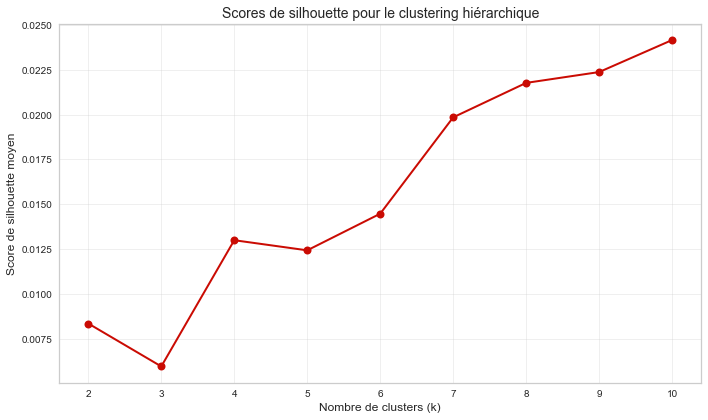

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(k_values_silhouette, silhouette_scores, 'ro-', linewidth=2, markersize=8)
plt.title('Scores de silhouette pour le clustering hiérarchique', fontsize=14)
plt.xlabel('Nombre de clusters (k)', fontsize=12)
plt.ylabel('Score de silhouette moyen', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(k_values_silhouette)
plt.tight_layout()
plt.show()

In [28]:
# Détermination du k optimal
optimal_k_silhouette = k_values_silhouette[np.argmax(silhouette_scores)]
print(f"\nNombre optimal de clusters selon la méthode silhouette: {optimal_k_silhouette}")
print(f"Score de silhouette maximal: {max(silhouette_scores):.4f}")


Nombre optimal de clusters selon la méthode silhouette: 10
Score de silhouette maximal: 0.0242


Résultats observés :

- Méthode du coude : WCSS décroît de 175.14 (k=2) à 153.21 (k=15)
- Score de silhouette optimal : k=10 avec un score de 0.0242

Conclusions :

- La décroissance régulière de la WCSS sans coude marqué indique une structure de données complexe
- Le score de silhouette faible (0.0242) suggère que les clusters ne sont pas très bien séparés, ce qui est typique pour des données textuelles d'hymnes nationaux
- k=10 clusters représente le meilleur compromis entre cohésion interne et séparation entre clusters

## 3.3 Application du clustering hiérarchique avec le nombre optimal de clusters


In [29]:
# Utilisation du nombre optimal de clusters déterminé par la méthode silhouette
k_optimal = optimal_k_silhouette
print(f"\nApplication du clustering hiérarchique avec k={k_optimal} clusters...")


Application du clustering hiérarchique avec k=10 clusters...


In [30]:
# Création du modèle de clustering hiérarchique
hierarchical_model = AgglomerativeClustering(n_clusters=k_optimal, linkage='ward')
cluster_labels_hierarchical = hierarchical_model.fit_predict(X_tfidf.toarray())

df['cluster_hierarchical'] = cluster_labels_hierarchical

print(f"\nRépartition des pays dans les {k_optimal} clusters:")
cluster_counts = pd.Series(cluster_labels_hierarchical).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    print(f"Cluster {cluster_id}: {count} pays")


Répartition des pays dans les 10 clusters:
Cluster 0: 37 pays
Cluster 1: 13 pays
Cluster 2: 65 pays
Cluster 3: 6 pays
Cluster 4: 31 pays
Cluster 5: 28 pays
Cluster 6: 2 pays
Cluster 7: 2 pays
Cluster 8: 4 pays
Cluster 9: 2 pays


In [31]:
print("\nPays par cluster:")
for cluster_id in range(k_optimal):
    pays_cluster = df[df['cluster_hierarchical'] == cluster_id]['Country'].tolist()
    print(f"\nCluster {cluster_id} ({len(pays_cluster)} pays):")
    print(", ".join(pays_cluster))


Pays par cluster:

Cluster 0 (37 pays):
Belgium, Estonia, Finland, France, Italy, Luxembourg, Portugal, Republic of North Macedonia, Romania, Slovakia, Spain, Ukraine, Argentina, Bolivia, Colombia, Ecuador, Paraguay, Uruguay, Venezuela, Mexico, Cuba, Dominican Republic, Papua New Guinea, Kiribati, Laos, Thailand, Angola, Burkina Faso, Burundi, Cape Verde, Equatorial Guinea, Ethiopia, Guinea, Mali, Sao Tome and Principe, Senegal, Tunisia

Cluster 1 (13 pays):
Azerbaijan, Iceland, Serbia, Switzerland, Brazil, Nicaragua, Tonga, India, Maldives, Philippines, Sri Lanka, Cameroon, Ivory Coast

Cluster 2 (65 pays):
Austria, Bosnia and Herzegovina, Czechia, Denmark, Germany, Ireland, Liechtenstein, Lithuania, Moldova (the Republic of), Montenegro, Norway, Poland, Slovenia, Sweden, Chile, Peru, Suriname, United States of America, Guatemala, Haiti, Honduras, Costa Rica, Panama, Puerto Rico, Trinidad and Tobago, Bahamas, Belize, Barbados, Greenland, Vanuatu, Samoa, Federated States of Micronesia

Résultats observés :

- Répartition inégale : Cluster 2 (65 pays) vs Clusters 6,7,9 (2 pays chacun)
- 10 clusters identifiés avec des tailles variables

Conclusions :

- La forte hétérogénéité des tailles révèle l'existence d'un groupe dominant thématiquement (Cluster 2)
- Les petits clusters (6,7,9) représentent probablement des hymnes avec des caractéristiques textuelles très spécifiques
- Cette distribution suggère que la majorité des hymnes partagent des thèmes universels (liberté, patrie, gloire)

## 3.4 Visualisation des clusters dans l'espace PCA


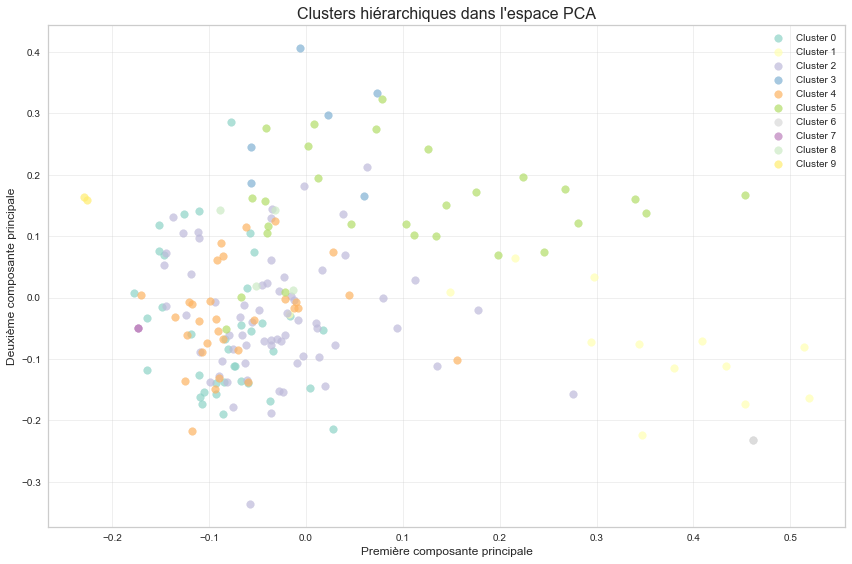

In [32]:
colors = plt.cm.Set3(np.linspace(0, 1, k_optimal))

plt.figure(figsize=(12, 8))
for cluster_id in range(k_optimal):
    cluster_mask = cluster_labels_hierarchical == cluster_id
    plt.scatter(X_pca[cluster_mask, 0], X_pca[cluster_mask, 1], 
               c=[colors[cluster_id]], label=f'Cluster {cluster_id}', 
               alpha=0.7, s=60)

plt.title('Clusters hiérarchiques dans l\'espace PCA', fontsize=16)
plt.xlabel('Première composante principale', fontsize=12)
plt.ylabel('Deuxième composante principale', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

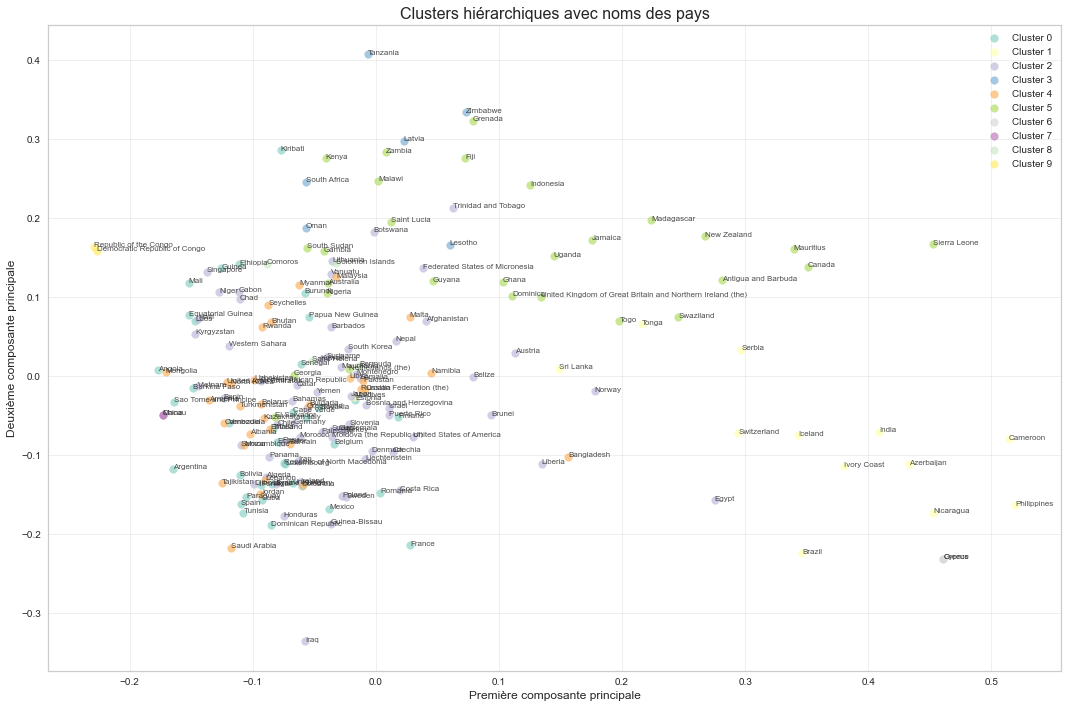

In [33]:
plt.figure(figsize=(15, 10))
for cluster_id in range(k_optimal):
    cluster_mask = cluster_labels_hierarchical == cluster_id
    plt.scatter(X_pca[cluster_mask, 0], X_pca[cluster_mask, 1], 
               c=[colors[cluster_id]], label=f'Cluster {cluster_id}', 
               alpha=0.7, s=60)

for i, country in enumerate(df['Country']):
    plt.annotate(country, (X_pca[i, 0], X_pca[i, 1]), 
                fontsize=8, alpha=0.8)

plt.title('Clusters hiérarchiques avec noms des pays', fontsize=16)
plt.xlabel('Première composante principale', fontsize=12)
plt.ylabel('Deuxième composante principale', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Résultats observés :

- Variance expliquée très faible : 4.19% pour les deux premières composantes
- Chevauchement important entre les clusters dans l'espace 2D

Conclusions :

- La faible variance expliquée confirme la haute dimensionnalité des données textuelles
- Le chevauchement visuel des clusters reflète la similarité thématique des hymnes nationaux
- Les hymnes utilisent un vocabulaire commun (liberté, patrie, gloire) rendant la séparation difficile en 2D

## 3.5 Visualisation géographique des clusters


In [34]:
df_map = df.copy()
df_map['cluster_hierarchical_str'] = df_map['cluster_hierarchical'].astype(str)
    
fig = px.choropleth(df_map,
                    locations='Alpha-3',
                    color='cluster_hierarchical_str',
                    hover_name='Country',
                    color_discrete_sequence=px.colors.qualitative.Set3,
                    title=f'Clustering hiérarchique des hymnes nationaux ({k_optimal} clusters)')
    
fig.update_layout(
    title_font_size=16,
    geo=dict(showframe=False, showcoastlines=True)
)
    
fig.show()

## 3.6 Analyse des mots les plus fréquents par cluster


In [35]:
def get_top_words_by_cluster(cluster_id, n_words=20):
    """
    Retourne les mots les plus fréquents pour un cluster donné.
    """
    cluster_mask = df['cluster_hierarchical'] == cluster_id
    cluster_texts = df[cluster_mask]['anthem_lemmatized'].fillna('')
    
    cluster_text = ' '.join(cluster_texts)
    
    tokens = word_tokenize(cluster_text)
    word_freq = Counter(tokens)
    
    return word_freq.most_common(n_words)

print("\nAnalyse des mots les plus fréquents par cluster:")
for cluster_id in range(k_optimal):
    print(f"\n--- Cluster {cluster_id} ---")
    top_words = get_top_words_by_cluster(cluster_id)
    for word, freq in top_words[:10]:
        print(f"{word}: {freq}")


Analyse des mots les plus fréquents par cluster:

--- Cluster 0 ---
people: 56
u: 50
glory: 42
liberty: 40
let: 40
freedom: 36
fatherland: 35
die: 33
one: 32
arm: 30

--- Cluster 1 ---
thy: 58
thou: 30
land: 20
salute: 19
thee: 18
god: 15
love: 13
thousand: 12
u: 12
year: 11

--- Cluster 2 ---
may: 78
land: 75
u: 71
homeland: 53
shall: 44
free: 37
god: 37
let: 35
flag: 33
people: 32

--- Cluster 3 ---
bless: 20
u: 11
land: 11
protect: 10
may: 10
africa: 9
god: 5
oh: 5
lord: 5
tanzania: 5

--- Cluster 4 ---
country: 44
u: 38
glory: 23
people: 22
land: 21
flag: 20
god: 20
live: 19
world: 18
long: 17

--- Cluster 5 ---
land: 58
u: 48
god: 47
thee: 45
free: 33
thy: 29
may: 29
let: 29
stand: 26
ever: 26

--- Cluster 6 ---
thee: 4
light: 4
thy: 4
hail: 4
knew: 2
old: 2
divinely: 2
restored: 2
thine: 2
eye: 2

--- Cluster 7 ---
arise: 8
march: 8
brave: 4
enemy: 4
gunfire: 4
ye: 2
refuse: 2
slave: 2
flesh: 2
blood: 2

--- Cluster 8 ---
island: 16
st: 6
helena: 6
nation: 5
heart: 5
u: 5
bermud

Résultats observés :

- Cluster 0 : "people" (56), "glory" (42), "liberty" (40) → Thème démocratique
- Cluster 1 : "thy" (58), "thou" (30) → Langage archaïque/religieux
- Cluster 2 : "may" (78), "homeland" (53) → Vœux patriotiques
- Cluster 3 : "bless" (20), "africa" (9) → Thème religieux africain

Conclusions :

- Segmentation thématique claire : chaque cluster reflète des styles linguistiques distincts
- Cluster 1 : Influence des hymnes à tradition britannique (langage archaïque)
- Cluster 3 : Spécificité régionale africaine avec dimension religieuse
- Clusters 6,7 : Hymnes avec vocabulaire très spécialisé (Grèce/Chypre, Chine/Macao)

## 3.7 Nuages de mots par cluster


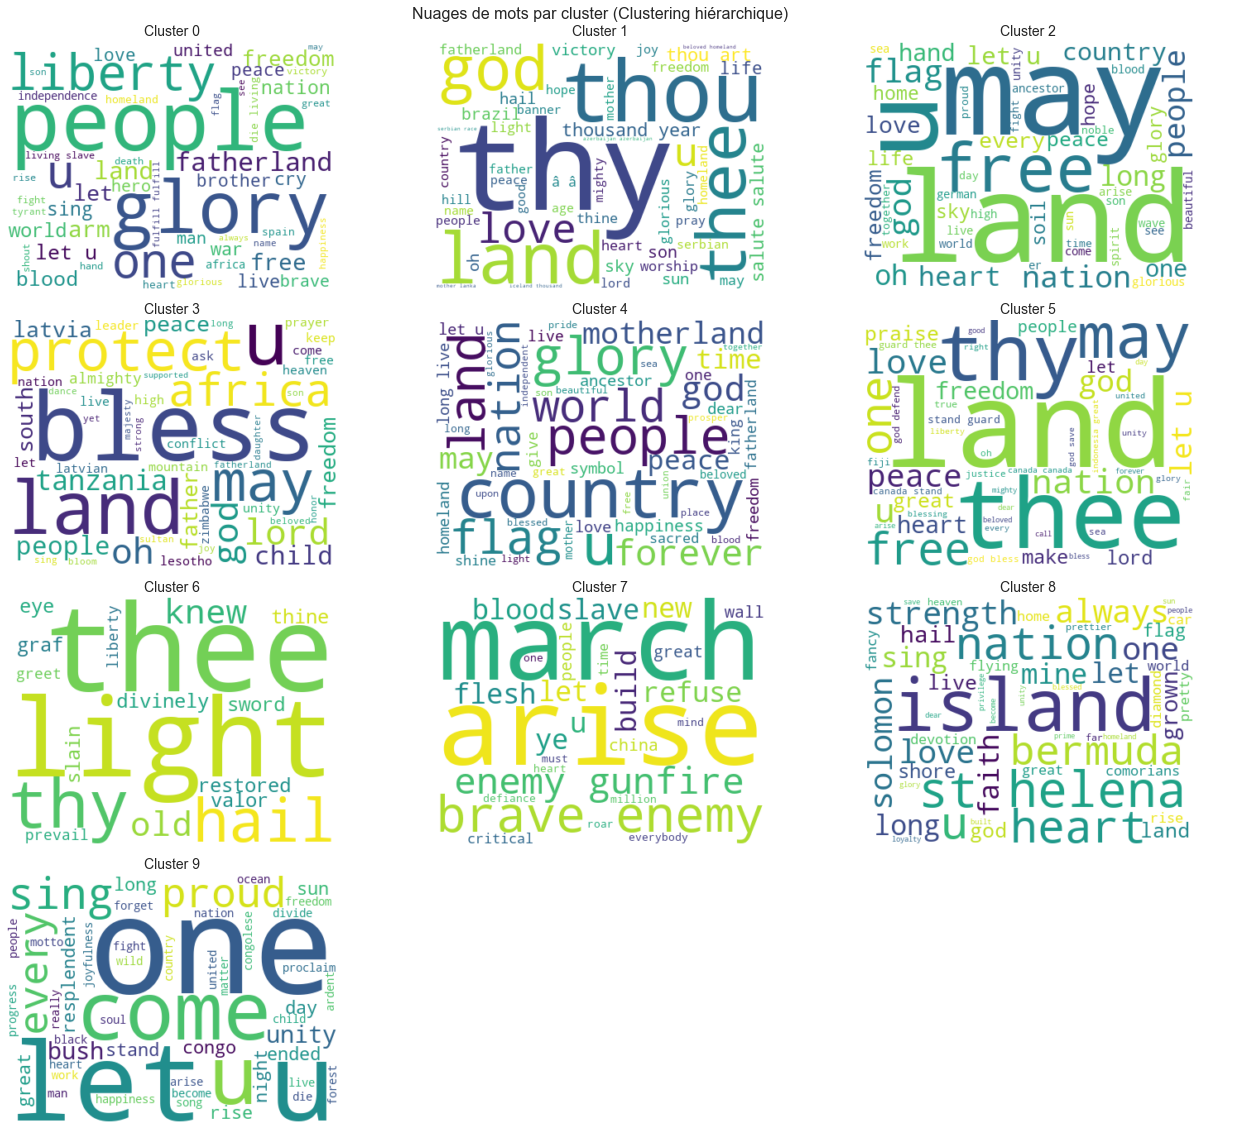

In [36]:
n_cols = 3
n_rows = (k_optimal + n_cols - 1) // n_cols 
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))

if n_rows == 1 and n_cols == 1:
    axes = [axes]
elif n_rows == 1 or n_cols == 1:
    axes = axes.flatten()
else:
    axes = axes.flatten()

for cluster_id in range(k_optimal):
    cluster_mask = df['cluster_hierarchical'] == cluster_id
    cluster_texts = df[cluster_mask]['anthem_lemmatized'].fillna('')
    cluster_text = ' '.join(cluster_texts)
    
    if cluster_text.strip():
        wordcloud = WordCloud(width=400, height=300, 
                             background_color='white',
                             max_words=50,
                             contour_width=2,
                             contour_color='steelblue').generate(cluster_text)
        
        axes[cluster_id].imshow(wordcloud, interpolation='bilinear')
        axes[cluster_id].set_title(f'Cluster {cluster_id}', fontsize=14)
        axes[cluster_id].axis('off')
    else:
        axes[cluster_id].text(0.5, 0.5, 'Pas de texte\ndisponible', 
                             ha='center', va='center', transform=axes[cluster_id].transAxes)
        axes[cluster_id].set_title(f'Cluster {cluster_id}', fontsize=14)
        axes[cluster_id].axis('off')

total_subplots = n_rows * n_cols
for i in range(k_optimal, total_subplots):
    axes[i].axis('off')

plt.suptitle('Nuages de mots par cluster (Clustering hiérarchique)', fontsize=16)
plt.tight_layout()
plt.show()

Conclusions :

- Visualisation confirme les différences thématiques identifiées
- Taille des mots révèle l'importance relative des concepts dans chaque cluster
- Diversité stylistique : du langage moderne démocratique au vocabulaire traditionnel

## 3.8 Analyse comparative des continents par cluster


In [37]:
print("\nRépartition des continents par cluster:")
continent_cluster_analysis = pd.crosstab(df['Continent'], df['cluster_hierarchical'])
display(continent_cluster_analysis)


Répartition des continents par cluster:


cluster_hierarchical   0  1   2  3   4   5  6  7  8  9
Continent                                             
Africa                11  2  16  4   6  13  0  0  2  2
Asia                   2  4  17  1  17   1  0  2  0  0
Europe                12  4  14  1   8   3  2  0  0  0
North_America          3  1  12  0   0   7  0  0  1  0
Oceania                2  1   3  0   0   3  0  0  1  0
South_America          7  1   3  0   0   1  0  0  0  0

<Figure size 864x576 with 0 Axes>

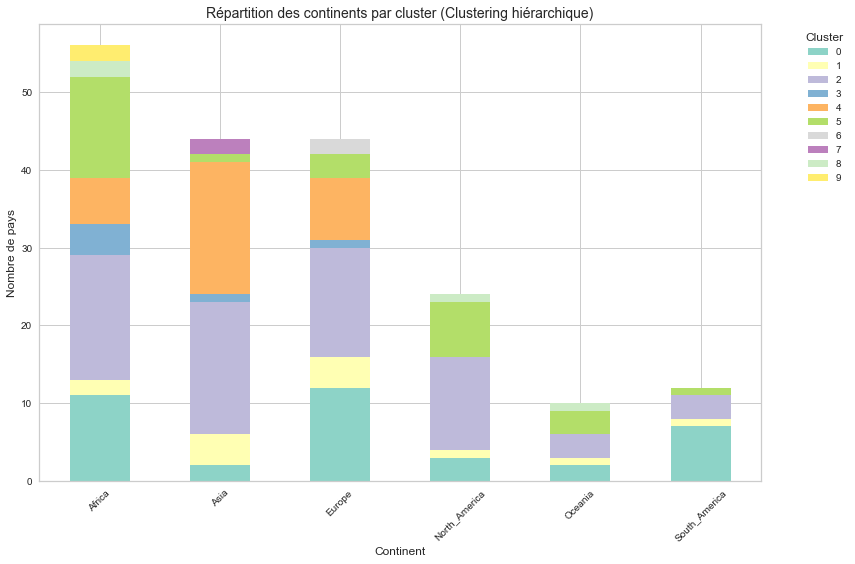

In [38]:
plt.figure(figsize=(12, 8))
continent_cluster_analysis.plot(kind='bar', stacked=True, 
                               colormap='Set3', figsize=(12, 8))
plt.title('Répartition des continents par cluster (Clustering hiérarchique)', fontsize=14)
plt.xlabel('Continent', fontsize=12)
plt.ylabel('Nombre de pays', fontsize=12)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [39]:
continent_cluster_percent = pd.crosstab(df['Continent'], df['cluster_hierarchical'], 
                                       normalize='index') * 100
print("\nPourcentages de répartition des continents par cluster:")
display(continent_cluster_percent.round(1))


Pourcentages de répartition des continents par cluster:


cluster_hierarchical     0     1     2    3     4     5    6    7     8    9
Continent                                                                   
Africa                19.6   3.6  28.6  7.1  10.7  23.2  0.0  0.0   3.6  3.6
Asia                   4.5   9.1  38.6  2.3  38.6   2.3  0.0  4.5   0.0  0.0
Europe                27.3   9.1  31.8  2.3  18.2   6.8  4.5  0.0   0.0  0.0
North_America         12.5   4.2  50.0  0.0   0.0  29.2  0.0  0.0   4.2  0.0
Oceania               20.0  10.0  30.0  0.0   0.0  30.0  0.0  0.0  10.0  0.0
South_America         58.3   8.3  25.0  0.0   0.0   8.3  0.0  0.0   0.0  0.0

Résultats observés :

- Cluster 2 : Plus cosmopolite (38.6% Asie, 31.8% Europe, 28.6% Afrique)
- Cluster 6 : 100% Europe (Grèce, Chypre)
- Cluster 7 : 100% Asie (Chine, Macao)

Conclusions :

- Pas de clustering purement géographique : les similitudes textuelles transcendent les frontières
- Quelques exceptions notables : Clusters 6 et 7 montrent une cohérence géographique/culturelle
- Les influences historiques (colonisation, échanges culturels) expliquent mieux les regroupements que la géographie pure

## 3.9 Comparaison avec une classification géographique

In [40]:
print("\nAnalyse de cohérence géographique:")
for cluster_id in range(k_optimal):
    cluster_countries = df[df['cluster_hierarchical'] == cluster_id]
    continents_in_cluster = cluster_countries['Continent'].value_counts()
    
    print(f"\nCluster {cluster_id}:")
    print(f"Continents représentés: {continents_in_cluster.to_dict()}")
    
    if len(continents_in_cluster) > 0:
        proportions = continents_in_cluster / continents_in_cluster.sum()
        entropy = -np.sum(proportions * np.log2(proportions))
        print(f"Entropie géographique: {entropy:.3f}")
        
        if entropy < 1.0:
            print("Cluster géographiquement homogène")
        elif entropy < 2.0:
            print("Cluster géographiquement moyennement diversifié")
        else:
            print("Cluster géographiquement très diversifié")

print("\n" + "="*80)
print("RÉSUMÉ DU CLUSTERING HIÉRARCHIQUE")
print("="*80)
print(f"Nombre optimal de clusters: {k_optimal}")
print(f"Score de silhouette: {silhouette_avg:.4f}")
print(f"Répartition des pays: {dict(cluster_counts)}")
print("="*80)


Analyse de cohérence géographique:

Cluster 0:
Continents représentés: {'Europe': 12, 'Africa': 11, 'South_America': 7, 'North_America': 3, 'Asia': 2, 'Oceania': 2}
Entropie géographique: 2.251
Cluster géographiquement très diversifié

Cluster 1:
Continents représentés: {'Asia': 4, 'Europe': 4, 'Africa': 2, 'North_America': 1, 'Oceania': 1, 'South_America': 1}
Entropie géographique: 2.316
Cluster géographiquement très diversifié

Cluster 2:
Continents représentés: {'Asia': 17, 'Africa': 16, 'Europe': 14, 'North_America': 12, 'Oceania': 3, 'South_America': 3}
Entropie géographique: 2.341
Cluster géographiquement très diversifié

Cluster 3:
Continents représentés: {'Africa': 4, 'Asia': 1, 'Europe': 1}
Entropie géographique: 1.252
Cluster géographiquement moyennement diversifié

Cluster 4:
Continents représentés: {'Asia': 17, 'Europe': 8, 'Africa': 6}
Entropie géographique: 1.438
Cluster géographiquement moyennement diversifié

Cluster 5:
Continents représentés: {'Africa': 13, 'North_Ame

Résultats observés :

- 3 clusters homogènes géographiquement (6,7,9)
- 7 clusters très diversifiés géographiquement
- Entropie géographique élevée pour la majorité des clusters

Conclusions :

- Les hymnes nationaux transcendent largement les frontières géographiques dans leur expression
- Les influences culturelles, historiques et linguistiques sont plus déterminantes que la proximité géographique
- Seuls quelques cas spéciaux maintiennent une cohérence géographique (liens culturels forts)

### Le clustering hiérarchique révèle que :

- Les hymnes nationaux forment un corpus relativement homogène avec des variations stylistiques subtiles
- Les regroupements reflètent davantage les influences historiques et linguistiques que la géographie
- Malgré un score de silhouette faible, l'analyse capture des nuances significatives entre traditions hymniques
- La méthode identifie avec succès des familles d'hymnes partageant des caractéristiques stylistiques communes
- L'universalité des thèmes patriotiques explique la difficulté de séparation nette entre clusters